# Contact Map Calculation for Multiple Structures

**Motivation:** We want to develop a function to calculate contact map or distance matrix based on minimal atomic distances between all heavy atoms of two residues.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from mmtfPyspark.io import mmtfReader, mmtfWriter
from mmtfPyspark.webfilters import Pisces
from mmtfPyspark.mappers import StructureToPolymerChains
from mmtfPyspark.utils import traverseStructureHierarchy, ColumnarStructure
from mmtfPyspark import structureViewer
from mmtfPyspark.filters import ContainsGroup, ContainsLProteinChain, PolymerComposition, Resolution 
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

A function for run length encoding. 

In [118]:
def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                  # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

Main function for contact map calcultaion over a single structure.

In [151]:
def cmap(structure, dcut=4.5, scut=2, binary=True):
    arrays = ColumnarStructure(structure, firstModelOnly=True)
    x = arrays.get_x_coords()
    y = arrays.get_y_coords()
    z = arrays.get_z_coords()
#    entity_types = arrays.get_entity_types()
#    cb_idx = entity_types == 'PRO'
#    xc = x[cb_idx]
#    yc = y[cb_idx]
#    zc = z[cb_idx]
#    coords = np.swapaxes(np.array([xc,yc,zc]), 0, 1)
    coords = np.swapaxes(np.array([x,y,z]), 0, 1)
    dist_matrix = squareform(pdist(coords), 'euclidean')
    ch = arrays.get_chain_ids()
    resno = arrays.get_group_numbers()
    string = ch + resno
#    unq = np.unique(string)
    inds = rle(string)
    nres = len(inds[0])
    dm = np.zeros((nres, nres))
    for i in range(0,(nres-scut)):
        for j in range((i+scut),nres):
            dist = np.min(dist_matrix[inds[1][i]:(inds[1][i]+inds[0][i]), inds[1][j]:(inds[1][j]+inds[0][j])])
            if binary:
                dm[i,j] = int(dist <= dcut)
            else:
                dm[i,j] = dist
    return dm  
#    return dist_matrix
#   atom_names = arrays.get_atom_names()
#    noh_idx = (atom_names = 'H*')

Configure Spark

In [4]:
spark = SparkSession.builder.master("local[4]").appName("Hackthon").getOrCreate()
sc = spark.sparkContext

In [5]:
path = "../resources/mmtf_full_sample"

pdb = mmtfReader.read_sequence_file(path, sc)

Filter for non-redundant structures.

In [6]:
nr_chains = pdb \
    .filter(Pisces(sequenceIdentity=20, resolution = 1.6)) \
    .flatMap(StructureToPolymerChains()) \
    .filter(Pisces(sequenceIdentity=20, resolution = 1.6)) \
    .filter(ContainsLProteinChain())

Test for first 10 structures.

In [160]:
pdbids = nr_chains.keys().take(10)
pdbids

['4WN5.A',
 '4WND.B',
 '4WP9.A',
 '4WPG.A',
 '4WPK.A',
 '4WRI.A',
 '4WSF.A',
 '1GWM.A',
 '1GXU.A',
 '1GY7.B']

In [161]:
structures = nr_chains.filter(lambda x: x[0] in pdbids)

Example 1: Calculate binary contact maps.

In [162]:
cm1 = structures.map(lambda x: cmap(x[1]))

In [163]:
cm1 = cm1.collect()
#help(ColumnarStructure)

In [164]:
cm1[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

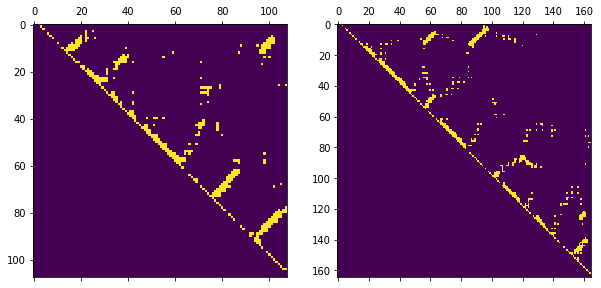

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 20)
ax1.matshow(cm1[0])
ax2.matshow(cm1[2])
plt.show()

Example 2: Calculate residue distance maps.

In [171]:
cm2 = structures.map(lambda x: cmap(x[1], dcut=6.0, binary=False))

In [172]:
cm2 = cm2.collect()

In [159]:
cm2[0]

array([[ 0.        ,  0.        ,  3.1951917 , ..., 13.46760899,
        13.49323879,  9.40791284],
       [ 0.        ,  0.        ,  0.        , ..., 15.01577843,
        15.67065098, 10.50114532],
       [ 0.        ,  0.        ,  0.        , ..., 16.01452619,
        17.57553695, 14.91523637],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  4.64250676],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

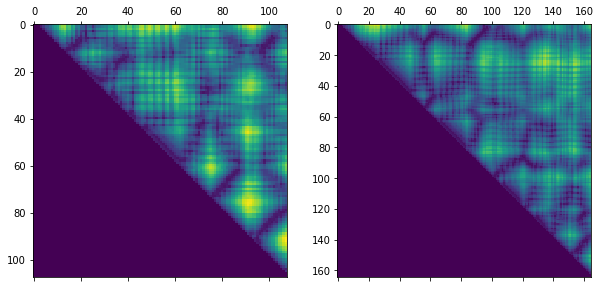

In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 20)
ax1.matshow(cm2[0])
ax2.matshow(cm2[2])

In [ ]:
spark.stop()